Phase 1 : Data Loading and Preprocessing

Using device: cuda
Downloading/Loading MNIST Training data...
Downloading/Loading MNIST Test data...

Sample image shape: torch.Size([1, 32, 32])
Sample image min value: 0.0
Sample image max value: 1.0


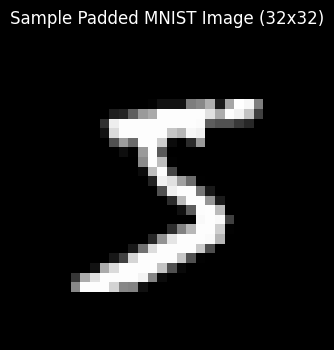

In [1]:
# Cell 1: Load MNIST Data and Initial Transformations

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Check for CUDA availability (GPU) - Assuming 'device' is defined from Cell 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") # Should already be defined

# Define transformations
# 1. Pad to 32x32: MNIST is 28x28, pad with 2 pixels on each side (value=0)
# 2. Convert to PyTorch Tensor: Changes image from PIL/NumPy to Tensor
# 3. (Scaling to [0,1] is usually handled by ToTensor for MNIST, but we verify)
transform = transforms.Compose([
    transforms.Pad(2), # Pad(padding, fill=0, padding_mode='constant') default fill=0
    transforms.ToTensor()
])

# Download and load the training data
print("Downloading/Loading MNIST Training data...")
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Download and load the test data
print("Downloading/Loading MNIST Test data...")
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Verify image shape and value range
sample_image, _ = trainset[0]
print(f"\nSample image shape: {sample_image.shape}") # Should be [1, 32, 32]
print(f"Sample image min value: {sample_image.min().item()}") # Should be 0.0
print(f"Sample image max value: {sample_image.max().item()}") # Should be 1.0

# Display a sample image after padding
plt.figure(figsize=(4, 4))
plt.imshow(sample_image.squeeze().numpy(), cmap='gray') # Squeeze removes channel dim
plt.title("Sample Padded MNIST Image (32x32)")
plt.axis('off')
plt.show()

In [2]:
# Cell 2 (Corrected): Define Preprocessing Functions (Logit and Inverse)
import torch # Make sure torch is imported

alpha = 0.05 # As used in the paper
epsilon = 1e-6 # Define epsilon for clamping

def preprocess_logit(x, alpha=0.05, epsilon=1e-6):
    """Applies the logit preprocessing: y = logit(a + (1-a)x) with clamping"""
    # Clamp x to be slightly away from 0 and 1 BEFORE scaling
    x_clamped = torch.clamp(x, epsilon, 1.0 - epsilon)
    # Scale to [a + (1-a)eps, a + (1-a)(1-eps)] which is approx [a, 1-a]
    x_scaled = alpha + (1 - alpha) * x_clamped
    # Apply logit: log(p / (1-p)) - Should now be safe
    y = torch.log(x_scaled) - torch.log1p(-x_scaled) # More stable logit calculation
    # y = torch.log(x_scaled / (1.0 - x_scaled)) # Original version (less stable)
    return y

def postprocess_sigmoid(y, alpha=0.05):
    """Applies the inverse of the logit preprocessing."""
    # Apply sigmoid (inverse of logit): p = 1 / (1 + exp(-y))
    p = torch.sigmoid(y)
    # Rescale from [a, 1-a] back to [0, 1]
    x = (p - alpha) / (1 - alpha)
    # Clamp values to ensure they are strictly within [0, 1]
    x = torch.clamp(x, 0.0, 1.0)
    return x

# --- Test the functions ---
# Make sure sample_image is defined (e.g., reload from dataset if needed)
try:
    sample_image
except NameError:
    print("Reloading sample_image...")
    # Need transform from Cell 18
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    sample_image, _ = trainset[0]

print(f"Original sample image min/max: {sample_image.min().item():.2f}/{sample_image.max().item():.2f}")

# Preprocess
sample_image_y = preprocess_logit(sample_image, alpha=alpha, epsilon=epsilon)
print(f"Preprocessed sample image min/max: {sample_image_y.min().item():.2f}/{sample_image_y.max().item():.2f}")
# Check for NaNs
if torch.isnan(sample_image_y).any():
    print("!!! WARNING: NaNs detected after preprocessing !!!")
else:
    print("No NaNs detected after preprocessing.")


# Postprocess
sample_image_x_recon = postprocess_sigmoid(sample_image_y, alpha=alpha)
print(f"Reconstructed sample image min/max: {sample_image_x_recon.min().item():.2f}/{sample_image_x_recon.max().item():.2f}")
reconstruction_error = torch.mean((sample_image - sample_image_x_recon)**2)
print(f"Preprocessing Reconstruction Error (MSE): {reconstruction_error.item():.8f}") # Should be very small

Original sample image min/max: 0.00/1.00
Preprocessed sample image min/max: -2.94/13.86
No NaNs detected after preprocessing.
Reconstructed sample image min/max: 0.00/1.00
Preprocessing Reconstruction Error (MSE): 0.00000000


In [3]:
# Cell 3 (Corrected): Define Preprocessing Log-Determinant Jacobian Function
import numpy as np # Ensure numpy is imported

def log_det_jacobian_preprocess(x, alpha=0.05, epsilon=1e-6):
    """
    Computes the log determinant of the Jacobian for the preprocessing
    y = logit(a + (1-a)x). Uses clamping for stability.
    """
    # Clamp x slightly away from 0 and 1
    x_clamped = torch.clamp(x, epsilon, 1.0 - epsilon)

    # Calculate p = a + (1-a)x_clamped
    p = alpha + (1 - alpha) * x_clamped

    # Calculate derivative dy/dx = (1-a) / (p * (1-p))
    # Clamp denominator terms away from zero for safety
    p = torch.clamp(p, epsilon, 1.0 - epsilon) # Clamp p as well
    dy_dx = (1 - alpha) / (p * (1 - p))

    # Clamp derivative to avoid log(0) or log(negative) if something went wrong
    dy_dx_safe = torch.clamp(dy_dx, min=epsilon) # Prevent log(0) or log(neg)

    # Log determinant is sum of log(dy/dx) over all dimensions (pixels)
    log_det_j = torch.sum(torch.log(dy_dx_safe), dim=[1, 2, 3])

    return log_det_j

# --- Test the function ---
# Ensure device and sample_image are defined
try:
    device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    sample_image
except NameError:
    print("Reloading sample_image for test...")
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    sample_image, _ = trainset[0]


sample_image_batch = sample_image.unsqueeze(0).to(device)

log_det_j_preprocess = log_det_jacobian_preprocess(sample_image_batch, alpha=alpha, epsilon=epsilon)
print(f"Log det Jacobian for preprocessing (sample image): {log_det_j_preprocess.item():.4f}")
print(f"Shape of log det Jacobian: {log_det_j_preprocess.shape}") # Should be [batch_size]
if torch.isnan(log_det_j_preprocess).any():
     print("!!! WARNING: NaNs detected in log_det_j_preprocess !!!")
else:
     print("No NaNs detected in log_det_j_preprocess.")

Log det Jacobian for preprocessing (sample image): 3066.5898
Shape of log det Jacobian: torch.Size([1])
No NaNs detected in log_det_j_preprocess.


In [4]:
# Cell 4: Apply Preprocessing to Datasets and Create DataLoaders

batch_size = 64 # Use the batch size defined earlier or set a new one

# --- Function to apply preprocessing to a whole dataset ---
def apply_preprocessing_to_dataset(dataset, preprocess_func, device):
    processed_data = []
    # If using torchvision dataset directly:
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=2) # Use larger batch for faster processing
    print(f"Applying preprocessing to {len(dataset)} samples...")
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)
        # Add epsilon for numerical stability during preprocessing
        epsilon = 1e-6
        processed_images = preprocess_func(images + epsilon)
        processed_data.append(processed_images.cpu()) # Move back to CPU to accumulate
        if (i+1) % 20 == 0:
            print(f"  Processed batch {i+1}/{len(dataloader)}")
    print("Finished processing.")
    return torch.cat(processed_data, dim=0)

# Apply preprocessing to train and test sets
# Make sure 'device' is defined
processed_train_data = apply_preprocessing_to_dataset(trainset, preprocess_logit, device)
processed_test_data = apply_preprocessing_to_dataset(testset, preprocess_logit, device)

print(f"\nShape of processed training data: {processed_train_data.shape}")
print(f"Shape of processed test data: {processed_test_data.shape}")

# Create TensorDatasets from the processed data
# We don't need labels for unsupervised learning, but keep them as dummy if needed later
train_labels = torch.tensor(trainset.targets) # Get original labels
test_labels = torch.tensor(testset.targets)

processed_train_dataset = TensorDataset(processed_train_data, train_labels)
processed_test_dataset = TensorDataset(processed_test_data, test_labels)

# Create final DataLoaders for training
train_loader = DataLoader(processed_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(processed_test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=2, pin_memory=True) # Larger batch for testing often okay

print(f"\nCreated Train DataLoader with {len(train_loader)} batches.")
print(f"Created Test DataLoader with {len(test_loader)} batches.")

# --- Verify a batch from the loader ---
sample_batch, _ = next(iter(train_loader))
print(f"\nSample batch shape from train_loader: {sample_batch.shape}")
print(f"Sample batch min value: {sample_batch.min().item():.2f}") # Should be unbounded - nan? 
print(f"Sample batch max value: {sample_batch.max().item():.2f}") # Should be unbounded

print("\n--- Checking DataLoader Batch Device ---")
try:
    sample_batch_check, _ = next(iter(train_loader))
    sample_batch_check = sample_batch_check.to(device) # Explicitly move
    print(f"Sample batch loaded shape: {sample_batch_check.shape}, Device: {sample_batch_check.device}")
    if torch.isnan(sample_batch_check).any():
         print("!!! WARNING: NaNs detected in loaded batch !!!")
    else:
         print("Loaded batch seems okay (no NaNs).")
except NameError as e:
    print(f"Error checking DataLoader: {e}. Please ensure Phase 1 cells are run.")
print("--- Finished DataLoader Check ---")

Applying preprocessing to 60000 samples...
  Processed batch 20/118
  Processed batch 40/118
  Processed batch 60/118
  Processed batch 80/118
  Processed batch 100/118
Finished processing.
Applying preprocessing to 10000 samples...
  Processed batch 20/20
Finished processing.

Shape of processed training data: torch.Size([60000, 1, 32, 32])
Shape of processed test data: torch.Size([10000, 1, 32, 32])

Created Train DataLoader with 938 batches.
Created Test DataLoader with 79 batches.


/tmp/ipykernel_170198/805327884.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(trainset.targets) # Get original labels
/tmp/ipykernel_170198/805327884.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(testset.targets)



Sample batch shape from train_loader: torch.Size([64, 1, 32, 32])
Sample batch min value: -2.94
Sample batch max value: 13.86

--- Checking DataLoader Batch Device ---
Sample batch loaded shape: torch.Size([64, 1, 32, 32]), Device: cuda:0
Loaded batch seems okay (no NaNs).
--- Finished DataLoader Check ---


Phase 2 : Multi-Scale Real NVP Implementation

In [5]:
# Cell 5 (Simplified & Robust Device Handling): Masking Utilities & MaskedConv2d Layer

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- Ensure 'device' is defined ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

def create_checkerboard_mask(height, width, invert=False, device='cpu'):
    # (Keep implementation as before)
    mask = torch.arange(height, device=device).view(-1, 1) + torch.arange(width, device=device)
    mask = (mask % 2).float()
    if invert:
        mask = 1 - mask
    return mask.unsqueeze(0).unsqueeze(0)

def create_channel_mask(num_channels, invert=False, device='cpu'):
    # (Keep implementation as before)
    mask = torch.cat([
        torch.ones(num_channels // 2, device=device),
        torch.zeros(num_channels - num_channels // 2, device=device)
    ], dim=0)
    if invert:
        mask = 1 - mask
    return mask.view(1, num_channels, 1, 1)

class MaskedConv2d(nn.Conv2d):
    # (Keep __init__ as before)
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if mask_type not in {'checkerboard', 'channel'}:
            raise ValueError(f"Unknown mask type: {mask_type}")
        self.mask_type = mask_type

    def forward(self, x):
        layer_idx_str = f" MaskedConv2d({self.in_channels}->{self.out_channels}, k={self.kernel_size}, type='{self.mask_type}') " # For print context
        target_device = self.weight.device
        # --- Debug Print ---
        # print(f"{layer_idx_str} Input device: {x.device}, Target (weight) device: {target_device}")

        if x.device != target_device:
            print(f"{layer_idx_str} WARNING: Moving input tensor from {x.device} to {target_device}")
            x = x.to(target_device)

        # Create mask dynamically on the target device
        in_channels = self.in_channels // self.groups
        height, width = x.size(2), x.size(3)

        mask = None
        if self.mask_type == 'channel':
            mask = create_channel_mask(in_channels, invert=False, device=target_device)
        elif self.mask_type == 'checkerboard':
            mask = torch.ones(1, 1, 1, 1, device=target_device)

        # --- Debug Print ---
        print(f"{layer_idx_str} Mask device: {mask.device}")

        # Apply mask to weights
        masked_weight = self.weight * mask # Broadcasting happens here

        # --- Debug Print ---
        # print(f"{layer_idx_str} Input device before F.conv2d: {x.device}")
        # print(f"{layer_idx_str} masked_weight device: {masked_weight.device}")
        # print(f"{layer_idx_str} bias device (if exists): {self.bias.device if self.bias is not None else 'None'}")

        # Perform convolution
        out = F.conv2d(x, masked_weight, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)

        # --- Debug Print ---
        # print(f"{layer_idx_str} Output device: {out.device}")
        return out


# --- Re-run Tests ---
print("--- Running Simplified Cell 5 Tests ---")
cb_mask = create_checkerboard_mask(4, 4, device=device)
print("Checkerboard Mask (4x4) shape:", cb_mask.shape, "Device:", cb_mask.device)
ch_mask = create_channel_mask(4, device=device)
print("Channel Mask (C=4) shape:", ch_mask.shape, "Device:", ch_mask.device)

dummy_input = torch.randn(2, 4, 8, 8).to(device)
masked_conv_ch = MaskedConv2d('channel', in_channels=4, out_channels=8, kernel_size=3, padding=1).to(device)
output_ch = masked_conv_ch(dummy_input)
print(f"MaskedConv2d ('channel') output shape: {output_ch.shape}")

masked_conv_cb = MaskedConv2d('checkerboard', in_channels=4, out_channels=8, kernel_size=3, padding=1).to(device)
output_cb = masked_conv_cb(dummy_input)
print(f"MaskedConv2d ('checkerboard') output shape: {output_cb.shape}")
print("--- Finished Simplified Cell 5 Tests ---")

--- Using device: cuda ---
--- Running Simplified Cell 5 Tests ---
Checkerboard Mask (4x4) shape: torch.Size([1, 1, 4, 4]) Device: cuda:0
Channel Mask (C=4) shape: torch.Size([1, 4, 1, 1]) Device: cuda:0
 MaskedConv2d(4->8, k=(3, 3), type='channel')  Mask device: cuda:0


MaskedConv2d ('channel') output shape: torch.Size([2, 8, 8, 8])
 MaskedConv2d(4->8, k=(3, 3), type='checkerboard')  Mask device: cuda:0
MaskedConv2d ('checkerboard') output shape: torch.Size([2, 8, 8, 8])
--- Finished Simplified Cell 5 Tests ---


In [6]:
# Cell 6: Convolutional s/t Network

class ConvNet(nn.Module):
    # (Keep __init__ as before, initializing layers)
    def __init__(self, in_channels, hidden_channels, out_channels, mask_type, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(MaskedConv2d(mask_type, in_channels, hidden_channels, kernel_size=3, padding=1))
        self.layers.append(nn.BatchNorm2d(hidden_channels))
        self.layers.append(nn.ReLU())

        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d(mask_type, hidden_channels, hidden_channels, kernel_size=3, padding=1))
            self.layers.append(nn.BatchNorm2d(hidden_channels))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1))
        self.layers[-1].weight.data.zero_()
        self.layers[-1].bias.data.zero_()

    def forward(self, x):
        # --- Debug Print ---
        # print(f"  ConvNet Start: Input device: {x.device}")
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # --- Debug Print ---
            # print(f"    ConvNet After Layer {i} ({type(layer).__name__}): Device: {x.device}")
        print(f"  ConvNet End: Output device: {x.device}")
        return x


# --- Test ConvNet ---
dummy_input = torch.randn(2, 4, 8, 8).to(device) # B, C, H, W
conv_net_ch = ConvNet(in_channels=4, hidden_channels=32, out_channels=4, mask_type='channel', num_layers=4).to(device)
output_st_ch = conv_net_ch(dummy_input)
print(f"ConvNet ('channel') output shape: {output_st_ch.shape}") # Should be [2, 4, 8, 8]

conv_net_cb = ConvNet(in_channels=4, hidden_channels=32, out_channels=4, mask_type='checkerboard', num_layers=4).to(device)
output_st_cb = conv_net_cb(dummy_input)
print(f"ConvNet ('checkerboard') output shape: {output_st_cb.shape}") # Should be [2, 4, 8, 8]

 MaskedConv2d(4->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
ConvNet ('channel') output shape: torch.Size([2, 4, 8, 8])
 MaskedConv2d(4->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
ConvNet ('checkerboard') output shape: torch.Size([2, 4, 8, 8])


In [7]:
# Cell 7 (Corrected Yet Again): Convolutional Affine Coupling Layer

import torch # Make sure torch, nn, F are imported
import torch.nn as nn
import torch.nn.functional as F
# Make sure ConvNet, create_checkerboard_mask, create_channel_mask are defined from previous cells

# Cell 7 (Debugged): Convolutional Affine Coupling Layer
# (Keep imports as before)
# Ensure ConvNet, create_*_mask are defined

class ConvCouplingLayer(nn.Module):
    # (Keep __init__ as before, initializing s_net, t_net, s_scale)
    def __init__(self, num_channels, hidden_channels, mask_type, invert_mask):
        super().__init__()
        self.num_channels = num_channels
        self.mask_type = mask_type
        self.invert_mask = invert_mask
        assert mask_type in ['checkerboard', 'channel']
        self.s_net = ConvNet(num_channels, hidden_channels, num_channels, mask_type=mask_type, num_layers=4)
        self.t_net = ConvNet(num_channels, hidden_channels, num_channels, mask_type=mask_type, num_layers=4)
        self.s_scale = nn.Parameter(torch.zeros(1)) # Initialized on CPU, relies on model.to(device)

    def forward(self, x, log_det_jacobian=0, reverse=False):
        layer_info = f"ConvCouple(C={self.num_channels}, type='{self.mask_type}', inv={self.invert_mask})"
        # --- Debug Print ---
        # print(f"  {layer_info} Start: Input x device: {x.device}, log_det device: {log_det_jacobian.device if isinstance(log_det_jacobian, torch.Tensor) else 'Scalar'}")

        if not x.is_contiguous(): x = x.contiguous()

        B, C, H, W = x.shape
        op_device = x.device # Device for internal ops

        # Create mask on the correct device
        if self.mask_type == 'checkerboard':
            mask = create_checkerboard_mask(H, W, self.invert_mask, device=op_device)
        else: # channel mask
            mask = create_channel_mask(C, self.invert_mask, device=op_device)

        # Mask the input
        x_masked = x * mask
        # --- Debug Print ---
        # print(f"    {layer_info} Mask device: {mask.device}, x_masked device: {x_masked.device}")

        # Pass to s/t networks
        s_unscaled = self.s_net(x_masked)
        t = self.t_net(x_masked)
        # --- Debug Print ---
        # print(f"    {layer_info} s_unscaled device: {s_unscaled.device}, t device: {t.device}")

        # Apply learned scaling and tanh
        # Check devices RIGHT BEFORE the problematic operation
        tanh_s_unscaled = torch.tanh(s_unscaled)
        # Check the parameter's actual device
        s_scale_current_device = self.s_scale.device
        # Perform the exp operation, moving s_scale if needed
        exp_s_scale = torch.exp(self.s_scale.to(op_device))

        # --- THE CRITICAL DEBUG PRINT ---
        # print(f"    {layer_info} BEFORE MULT: tanh_s device={tanh_s_unscaled.device}, exp_s_scale device={exp_s_scale.device}, s_scale param device={s_scale_current_device}, op_device={op_device}")

        # Multiplication - This is where the error occurred
        s = tanh_s_unscaled * exp_s_scale

        # Apply mask for transformation logic
        s = s * (1 - mask)
        t = t * (1 - mask)

        # Perform forward/reverse
        if not reverse:
            y = x * mask + (x * torch.exp(s) + t) * (1 - mask)
            log_det_jacobian = log_det_jacobian + torch.sum(s, dim=[1, 2, 3])
            output = y
        else:
            y = x # Rename input
            x_recon = y * mask + ((y - t) * torch.exp(-s)) * (1 - mask)
            log_det_jacobian = log_det_jacobian - torch.sum(s, dim=[1, 2, 3])
            output = x_recon

        if not output.is_contiguous(): output = output.contiguous()
        # --- Debug Print ---
        # print(f"  {layer_info} End: Output device: {output.device}, log_det device: {log_det_jacobian.device}")
        return output, log_det_jacobian


# --- Re-run Test (Optional but Recommended) ---
print("--- Running Corrected Cell 7 Tests ---")
# Ensure device, ConvNet, create_*_mask, dummy_input are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
try:
    dummy_input = torch.randn(2, 4, 8, 8).to(device) # B, C, H, W
    # Re-instantiate to be sure
    cc1 = ConvCouplingLayer(num_channels=4, hidden_channels=16, mask_type='checkerboard', invert_mask=False).to(device)
    out1, ld1 = cc1(dummy_input)
    # ... rest of the test ...
    print("Cell 7 test setup successful.")
    # Perform the full test if desired, otherwise just check instantiation
    cc2 = ConvCouplingLayer(num_channels=4, hidden_channels=16, mask_type='checkerboard', invert_mask=True).to(device)
    out2, ld2 = cc2(out1, ld1)
    cc3 = ConvCouplingLayer(num_channels=4, hidden_channels=16, mask_type='channel', invert_mask=False).to(device)
    out3, ld3 = cc3(out2, ld2)
    cc4 = ConvCouplingLayer(num_channels=4, hidden_channels=16, mask_type='channel', invert_mask=True).to(device)
    out4, ld4 = cc4(out3, ld3)
    print(f"ConvCoupling Test Output shape: {out4.shape}, Device: {out4.device}")
    print(f"ConvCoupling Test LogDet shape: {ld4.shape}, Device: {ld4.device}")
    rev4, _ = cc4(out4, reverse=True)
    rev3, _ = cc3(rev4, reverse=True)
    rev2, _ = cc2(rev3, reverse=True)
    rev1, rld1 = cc1(rev2, reverse=True)
    print(f"Reconstruction error: {torch.mean((dummy_input - rev1)**2).item():.6g}")
    print(f"LogDet after reverse: {rld1.mean().item():.6g}")
except Exception as e:
    print(f"Error during Cell 7 test: {e}")
print("--- Finished Corrected Cell 7 Tests ---")

--- Running Corrected Cell 7 Tests ---
Using device: cuda
 MaskedConv2d(4->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(4->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
Cell 7 test setup successful.
 MaskedConv2d(4->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(4->16, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(16->16, k=(3, 3), type='checkerboard')  Mask device

In [8]:
# Cell 8: Squeeze/Unsqueeze Operations

class Squeeze(nn.Module):
    # (Keep __init__ as before)
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        # --- Debug Print ---
        print(f"  Squeeze Start: Input device: {x.device}")
        B, C, H, W = x.size()
        assert H % self.factor == 0 and W % self.factor == 0, "Height/Width must be divisible by factor"
        x = x.view(B, C, H // self.factor, self.factor, W // self.factor, self.factor)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(B, C * (self.factor ** 2), H // self.factor, W // self.factor)
        # --- Debug Print ---
        print(f"  Squeeze End: Output device: {x.device}")
        return x

class Unsqueeze(nn.Module):
    # (Keep __init__ as before)
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        # --- Debug Print ---
        print(f"  Unsqueeze Start: Input device: {x.device}")
        B, C, H, W = x.size()
        assert C % (self.factor ** 2) == 0, "Channels must be divisible by factor^2"
        x = x.view(B, C // (self.factor ** 2), self.factor, self.factor, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(B, C // (self.factor ** 2), H * self.factor, W * self.factor)
        # --- Debug Print ---
        print(f"  Unsqueeze End: Output device: {x.device}")
        return x

# --- Test Squeeze/Unsqueeze ---
squeeze = Squeeze(factor=2)
unsqueeze = Unsqueeze(factor=2)
dummy_input = torch.randn(2, 4, 8, 8).to(device) # B, C, H, W
squeezed = squeeze(dummy_input)
print(f"Squeezed shape: {squeezed.shape}") # Should be [2, 16, 4, 4]
unsqueezed = unsqueeze(squeezed)
print(f"Unsqueeze(Squeeze(x)) shape: {unsqueezed.shape}") # Should be [2, 4, 8, 8]
print(f"Squeeze/Unsqueeze Reconstruction error: {torch.mean((dummy_input - unsqueezed)**2).item():.6g}") # Should be 0

  Squeeze Start: Input device: cuda:0
  Squeeze End: Output device: cuda:0
Squeezed shape: torch.Size([2, 16, 4, 4])
  Unsqueeze Start: Input device: cuda:0
  Unsqueeze End: Output device: cuda:0
Unsqueeze(Squeeze(x)) shape: torch.Size([2, 4, 8, 8])
Squeeze/Unsqueeze Reconstruction error: 0


In [9]:
# Cell 9 (Corrected Factoring Logic): Multi-Scale RealNVP Model
# (Keep imports and dependent class definitions)

class MultiScaleRealNVP(nn.Module):
    def __init__(self, in_channels, num_scales, layers_per_scale, hidden_channels, input_hw=(32, 32)):
        super().__init__()
        self.in_channels = in_channels
        self.num_scales = num_scales
        self.layers_per_scale = layers_per_scale
        self.input_hw = input_hw

        self.coupling_layers = nn.ModuleList()
        self.squeeze_ops = nn.ModuleList()
        self.latent_shapes = []
        current_channels = self.in_channels
        current_h, current_w = self.input_hw

        print(f"--- Building MultiScaleRealNVP ---")
        print(f"Input: C={current_channels}, H={current_h}, W={current_w}")

        for scale in range(num_scales):
            scale_coupling_layers = nn.ModuleList()
            num_layers = layers_per_scale[scale]
            print(f"  Scale {scale+1} (Layers={num_layers}, In C={current_channels}, H={current_h}, W={current_w}):")

            for i in range(num_layers):
                mask_type = 'checkerboard' if scale == 0 else 'channel'
                is_even_layer = i % 2 == 0
                scale_coupling_layers.append(
                    ConvCouplingLayer(
                        num_channels=current_channels,
                        hidden_channels=hidden_channels,
                        mask_type=mask_type,
                        invert_mask=is_even_layer
                    )
                )
            self.coupling_layers.append(scale_coupling_layers)

            if scale < num_scales - 1:
                # *** CORRECTED FACTORING LOGIC ***
                if current_channels < 2:
                    # Cannot factor if less than 2 channels
                    channels_to_factor = 0
                    remaining_channels = current_channels
                    print(f"    Scale {scale+1}: Not factoring (C < 2)")
                else:
                    channels_to_factor = current_channels // 2
                    remaining_channels = current_channels - channels_to_factor
                    print(f"    Scale {scale+1}: Factoring {channels_to_factor} channels.")

                # Store shape of factored part (even if 0 channels)
                # If channels_to_factor is 0, this shape won't be used later for splitting z_flat,
                # but we need a placeholder or consistent logic.
                # Let's only store shapes for non-zero factored parts.
                if channels_to_factor > 0:
                    self.latent_shapes.append((channels_to_factor, current_h, current_w))

                print(f"    Scale {scale+1}: Remaining {remaining_channels} channels.")
                current_channels = remaining_channels # Update channels *before* squeeze

                # Check if remaining channels is zero BEFORE squeeze
                if current_channels == 0:
                     raise ValueError(f"Error: 0 channels remaining before squeeze at Scale {scale+1}. Check factoring logic.")

                print(f"    Scale {scale+1}: Squeezing...")
                squeeze_op = Squeeze(factor=2)
                self.squeeze_ops.append(squeeze_op)
                current_channels *= 4 # Channels increase after squeeze
                current_h //= 2
                current_w //= 2
                print(f"    Scale {scale+1}: After squeeze C={current_channels}, H={current_h}, W={current_w}")
            else:
                # Last scale: all remaining channels form the last latent part
                print(f"  Scale {scale+1}: Final latent part C={current_channels}, H={current_h}, W={current_w}")
                if current_channels > 0: # Only add if non-zero
                     self.latent_shapes.append((current_channels, current_h, current_w))

        self.total_latent_dim = sum(c*h*w for c, h, w in self.latent_shapes)
        print(f"--- Total Latent Dimension Calculated: {self.total_latent_dim} ---")
        print(f"--- Latent Shapes (C, H, W): {self.latent_shapes} ---")


    def forward(self, x):
        log_det_jacobian = torch.zeros(x.shape[0], device=x.device)
        latents_factored_out = []
        h = x
        squeeze_idx = 0
        latent_shape_idx = 0 # Index for self.latent_shapes

        for scale in range(self.num_scales):
            for layer in self.coupling_layers[scale]:
                h, log_det_jacobian = layer(h, log_det_jacobian)

            if scale < self.num_scales - 1:
                # *** CORRECTED FACTORING LOGIC FOR FORWARD ***
                current_C_before_factor = h.shape[1]
                if current_C_before_factor < 2:
                     channels_to_factor = 0
                else:
                     channels_to_factor = current_C_before_factor // 2

                if channels_to_factor > 0:
                    # Verify against stored shape
                    expected_C, expected_H, expected_W = self.latent_shapes[latent_shape_idx]
                    assert channels_to_factor == expected_C, f"Factor channel mismatch at scale {scale+1}"
                    assert (h.shape[2], h.shape[3]) == (expected_H, expected_W), f"Factor spatial mismatch at scale {scale+1}"

                    z_out = h[:, :channels_to_factor, :, :]
                    h = h[:, channels_to_factor:, :, :] # Keep remaining
                    latents_factored_out.append(z_out)
                    latent_shape_idx += 1 # Increment index only when we add to latents_factored_out
                # else: h remains unchanged, latent_shape_idx does not increment

                # Apply Squeeze
                h = self.squeeze_ops[squeeze_idx](h)
                squeeze_idx += 1

        # Final h is the last latent part
        z_final = h
        if z_final.shape[1] > 0: # Only append if non-zero channels
            latents_factored_out.append(z_final)
            # Verify last shape
            expected_C, expected_H, expected_W = self.latent_shapes[-1]
            assert z_final.shape[1:] == (expected_C, expected_H, expected_W), \
                   f"Final latent shape mismatch! Got {z_final.shape[1:]}, Expected {self.latent_shapes[-1]}"


        # Concatenate flattened latents
        z_flat_parts = [z_part.view(z_part.shape[0], -1) for z_part in latents_factored_out]
        if not z_flat_parts: # Handle case where total_latent_dim might be 0 (shouldn't happen with MNIST)
            return torch.empty(x.shape[0], 0, device=x.device), log_det_jacobian
        z_flat = torch.cat(z_flat_parts, dim=1)

        # Final dimension check
        assert z_flat.shape[1] == self.total_latent_dim, \
            f"Final z_flat dim mismatch! Got {z_flat.shape[1]}, Expected {self.total_latent_dim}"

        return z_flat, log_det_jacobian


    def inverse(self, z_flat):
        # Check total dimension using stored value
        if self.total_latent_dim == 0 and z_flat.shape[1] == 0:
             print("Warning: Inverse called with 0 latent dim. Returning empty tensor matching input size.")
             # Need a way to determine original input spatial size if possible
             # Assuming default 32x32 for now
             B = z_flat.shape[0]
             return torch.empty(B, self.in_channels, self.input_hw[0], self.input_hw[1], device=z_flat.device)

        assert z_flat.shape[1] == self.total_latent_dim, \
            f"Input z_flat dimension mismatch! Got {z_flat.shape[1]}, Expected {self.total_latent_dim}"

        # Split z_flat according to stored shapes
        latents_split = []
        current_idx = 0
        B = z_flat.shape[0]
        op_device = z_flat.device

        # Create a reversed list of shapes to pop from
        shapes_to_pop = self.latent_shapes[::-1]

        for i, (C_part, H_part, W_part) in enumerate(shapes_to_pop):
            num_elements = C_part * H_part * W_part
            # Split from the *end* of z_flat based on reversed shapes
            z_part_flat = z_flat[:, -(current_idx + num_elements) : (None if current_idx==0 else -current_idx) ]
            z_part = z_part_flat.view(B, C_part, H_part, W_part)
            latents_split.append(z_part)
            current_idx += num_elements

        # --- Reverse the process ---
        h = latents_split.pop(0) # Start with final latent part (first in reversed shapes list)
        squeeze_idx = len(self.squeeze_ops) - 1

        for scale in range(self.num_scales - 1, -1, -1):
            # Unsqueeze and Unfactor
            if scale < self.num_scales - 1:
                factor = self.squeeze_ops[squeeze_idx].factor
                unsqueeze_op = Unsqueeze(factor=factor).to(op_device)
                h = unsqueeze_op(h)
                squeeze_idx -= 1

                # Un-Factor: If shapes_to_pop still has items, the next one is the factored part
                if latents_split: # Check if there are more parts to pop
                     z_out = latents_split.pop(0) # Get the part factored at this scale
                     h = torch.cat([z_out.to(op_device), h], dim=1)
                # else: No part was factored at this scale (e.g., only 1 channel)


            # Apply inverse coupling layers
            for layer in reversed(self.coupling_layers[scale]):
                h, _ = layer(h, reverse=True)

        x_preprocessed = h
        return x_preprocessed

    # --- Sample and loss_function remain the same ---
    def sample(self, num_samples):
        op_device = next(self.parameters()).device
        with torch.no_grad():
            if self.total_latent_dim == 0: # Handle edge case
                 print("Warning: Sampling called with 0 latent dim.")
                 return torch.empty(num_samples, self.in_channels, self.input_hw[0], self.input_hw[1], device=op_device)
            z_flat = torch.randn(num_samples, self.total_latent_dim).to(op_device)
            x_preprocessed = self.inverse(z_flat)
        return x_preprocessed

    def loss_function(self, x):
        op_device = x.device
        prior = torch.distributions.Normal(torch.tensor(0.).to(op_device), torch.tensor(1.).to(op_device))
        z_flat, log_det_j_flow = self.forward(x)
        # Handle zero-dim latent space if it occurs
        if z_flat.shape[1] == 0:
             print("Warning: 0-dim latent space in loss calculation.")
             log_pz = torch.zeros(x.shape[0], device=op_device) # Log prob of "nothing" is 0?
        else:
             log_pz = prior.log_prob(z_flat).sum(dim=1)
        log_px = log_pz + log_det_j_flow
        loss = -torch.mean(log_px)
        return loss


# --- Test --- (Keep test code mostly the same)
# (Ensure Phase 1 / loader cells have run)
print("\n--- Running Cell 9 Tests (Factoring Corrected) ---")
in_channels = 1
num_scales = 3
layers_per_scale = [3, 3, 4]
hidden_channels = 32
input_hw=(32, 32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model: {device}")

try:
    # Re-initialize train_loader if necessary
    # train_loader = DataLoader(...)

    model = MultiScaleRealNVP(in_channels, num_scales, layers_per_scale, hidden_channels, input_hw=input_hw).to(device)
    print(f"\nModel parameters device check: {next(model.parameters()).device}")
    print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

    sample_batch, _ = next(iter(train_loader))
    sample_batch = sample_batch.to(device)
    print(f"\nTesting Forward Pass with batch shape: {sample_batch.shape}, device: {sample_batch.device}")
    z_flat, log_det_j = model(sample_batch)
    print(f"Forward pass output z_flat shape: {z_flat.shape}, Device: {z_flat.device}")
    print(f"Forward pass output log_det_j shape: {log_det_j.shape}, Device: {log_det_j.device}")

    print("\nTesting Inverse Pass...")
    x_reconstructed = model.inverse(z_flat)
    print(f"Inverse pass output x_reconstructed shape: {x_reconstructed.shape}, Device: {x_reconstructed.device}")
    assert x_reconstructed.shape[1:] == (model.in_channels, model.input_hw[0], model.input_hw[1]), "Reconstruction shape mismatch!"
    reconstruction_error = torch.mean((sample_batch - x_reconstructed)**2)
    print(f"Reconstruction Error (Initial): {reconstruction_error.item():.6g}") # Check if reasonable

    print("\nTesting Sampling...")
    samples_preprocessed = model.sample(num_samples=4)
    print(f"Generated samples shape (preprocessed): {samples_preprocessed.shape}, Device: {samples_preprocessed.device}")
    assert samples_preprocessed.shape[1:] == (model.in_channels, model.input_hw[0], model.input_hw[1]), "Sample shape mismatch!"

    print("\nTesting Loss Function...")
    loss = model.loss_function(sample_batch)
    print(f"Calculated loss for batch: {loss.item():.4f}")

except NameError as e:
    print(f"Error during test: {e}. Please ensure previous cells (incl. Phase 1) are run.")
except Exception as e:
     print(f"An unexpected error occurred during testing: {e}")
     import traceback
     traceback.print_exc()

print("--- Finished Cell 9 Tests ---")


--- Running Cell 9 Tests (Factoring Corrected) ---
Using device for model: cuda
--- Building MultiScaleRealNVP ---
Input: C=1, H=32, W=32
  Scale 1 (Layers=3, In C=1, H=32, W=32):
    Scale 1: Not factoring (C < 2)
    Scale 1: Remaining 1 channels.
    Scale 1: Squeezing...
    Scale 1: After squeeze C=4, H=16, W=16
  Scale 2 (Layers=3, In C=4, H=16, W=16):
    Scale 2: Factoring 2 channels.
    Scale 2: Remaining 2 channels.
    Scale 2: Squeezing...
    Scale 2: After squeeze C=8, H=8, W=8
  Scale 3 (Layers=4, In C=8, H=8, W=8):
  Scale 3: Final latent part C=8, H=8, W=8
--- Total Latent Dimension Calculated: 1024 ---
--- Latent Shapes (C, H, W): [(2, 16, 16), (8, 8, 8)] ---

Model parameters device check: cuda:0
Model initialized with 428,648 trainable parameters.



Testing Forward Pass with batch shape: torch.Size([64, 1, 32, 32]), device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cu

Phase 3 : Training and Evaluation

In [10]:
# Cell 10: Training Configuration (MNIST)

# --- Ensure model, train_loader, test_loader, device are defined ---
# model = MultiScaleRealNVP(...) from Cell 9
# train_loader, test_loader from Cell 21
# device from Cell 1

# Training Hyperparameters
mnist_learning_rate = 1e-4 # Often need lower LR for deeper conv models
mnist_batch_size = 64    # From Cell 21 setup
mnist_num_epochs = 50   # Start with fewer epochs, can increase later
mnist_print_every = 1     # Print loss every epoch
mnist_vis_every = 5      # Visualize generated samples every 5 epochs
mnist_weight_decay = 5e-5 # L2 penalty on s_scale, as mentioned in paper

# Optimizer
# Apply weight decay ONLY to the s_scale parameters
s_scale_params = [p for name, p in model.named_parameters() if 's_scale' in name]
other_params = [p for name, p in model.named_parameters() if 's_scale' not in name]

optimizer = torch.optim.Adam([
    {'params': other_params},
    {'params': s_scale_params, 'weight_decay': mnist_weight_decay}
], lr=mnist_learning_rate)

print("--- MNIST Training Configuration ---")
print(f"Learning Rate: {mnist_learning_rate}")
print(f"Batch Size: {mnist_batch_size}")
print(f"Num Epochs: {mnist_num_epochs}")
print(f"Weight Decay on s_scale: {mnist_weight_decay}")
print(f"Optimizer: Adam")
print(f"Model is on device: {next(model.parameters()).device}") # Verify model device

--- MNIST Training Configuration ---
Learning Rate: 0.0001
Batch Size: 64
Num Epochs: 50
Weight Decay on s_scale: 5e-05
Optimizer: Adam
Model is on device: cuda:0


--- Testing Visualization (Untrained Model) ---
 MaskedConv2d(8->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(8->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(8->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(8->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='channel')  Mask device: cuda:0
  ConvNet End: Ou

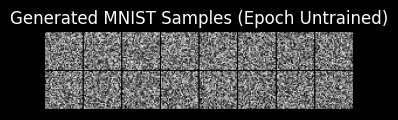

--- Finished Visualization Test ---


In [11]:
# Cell 11: MNIST Visualization Function

def visualize_mnist_samples(model, epoch, num_samples=64, figsize=(8, 8)):
    """Generates samples from the model and displays them."""
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        # Sample latent vectors and generate preprocessed images
        samples_preprocessed = model.sample(num_samples=num_samples)
        # Postprocess samples back to image range [0, 1]
        samples_image = postprocess_sigmoid(samples_preprocessed) # Use function from Cell 19

    # Move samples to CPU for plotting
    samples_image = samples_image.cpu()

    # Create grid and display
    plt.figure(figsize=figsize)
    grid_img = torchvision.utils.make_grid(samples_image, nrow=8, padding=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray') # Permute C, H, W -> H, W, C
    plt.title(f"Generated MNIST Samples (Epoch {epoch})")
    plt.axis('off')
    plt.show()

# --- Test visualization function with untrained model ---
print("--- Testing Visualization (Untrained Model) ---")
# Ensure model is defined and on device
try:
    visualize_mnist_samples(model, epoch="Untrained", num_samples=16, figsize=(4,4))
except NameError:
    print("Model not defined. Please run previous cells.")
except Exception as e:
    print(f"Error during visualization test: {e}")
print("--- Finished Visualization Test ---")

In [ ]:
# Cell 12: MNIST Training Loop

# --- Ensure model, optimizer, train_loader, device are defined ---
# --- Ensure visualize_mnist_samples is defined ---
import time 
train_losses = []
print("\n--- Starting MNIST Training ---")

model.train() # Set model to training mode

for epoch in range(mnist_num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0.0
    num_batches = 0

    for batch_idx, (batch_x, _) in enumerate(train_loader): # Use train_loader with preprocessed data
        # Data is already preprocessed, just move to device
        batch_x = batch_x.to(device)

        optimizer.zero_grad()

        # Use the model's internal loss function
        loss = model.loss_function(batch_x)

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"!!! ERROR: NaN loss encountered at Epoch {epoch+1}, Batch {batch_idx}. Stopping training. !!!")
            # Consider saving model state before error if needed
            # torch.save(model.state_dict(), "model_nan_error.pth")
            raise ValueError("NaN loss detected")


        loss.backward()
        # Optional: Gradient clipping (can help stability)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        # Optional: Print progress within epoch
        # if (batch_idx + 1) % 100 == 0:
        #    print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Current Loss: {loss.item():.4f}")


    avg_epoch_loss = epoch_loss / num_batches
    train_losses.append(avg_epoch_loss)
    epoch_end_time = time.time()

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{mnist_num_epochs}], Loss: {avg_epoch_loss:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

    # Visualize samples periodically
    if (epoch + 1) % mnist_vis_every == 0 or epoch == 0:
        print(f"--- Visualizing samples at Epoch {epoch+1} ---")
        visualize_mnist_samples(model, epoch=epoch+1)
        model.train() # Set back to train mode after visualization

print("\n--- MNIST Training Finished ---")

# Plot final training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("MNIST Training Loss (NLL)")
plt.xlabel("Epoch")
plt.ylabel("Average Negative Log-Likelihood")
plt.grid(True)
plt.show()

# Visualize final samples
print("\n--- Final Generated Samples ---")
visualize_mnist_samples(model, epoch=mnist_num_epochs)


--- Starting MNIST Training ---
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
  ConvNet End: Output device: cuda:0
 MaskedConv2d(1->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerboard')  Mask device: cuda:0
 MaskedConv2d(32->32, k=(3, 3), type='checkerb